In [1]:
# Import useful libraries
import math
import time
import config
import numpy as np
import pandas as pd
import os
import requests
import tweepy
import json
from PIL import Image
from io import BytesIO
from IPython.display import display

# Visualization libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
class Color:
    blue = '\033[94m'
    green = '\033[92m'
    red = '\033[91m'
    bold = '\033[1m'
    underline = '\033[4m'
    end = '\033[0m'

## Gather and Read Data
---

In [3]:
# Read the twitter archive data provided
wrd_archive = pd.read_csv('./twitter-archive-enhanced.csv')
wrd_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [4]:
# Programmatically download the image predictions
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split('/')[-1]
response = requests.get(url)

start = time.time()
with open(file_name, 'wb') as f:
    f.write(response.content)
    
print('Process completed in {} seconds'.format(time.time()-start))

Process completed in 0.0030410289764404297 seconds


In [5]:
# Read in the image predictions
img_predictions = pd.read_csv('./image-predictions.tsv', sep='\t')
img_predictions.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [6]:
# Create an API object to gater twitter data
consumer_key = config.API_KEY
consumer_secret = config.API_KEY_SECRET
access_token = config.ACCESS_TOKEN
access_secret = config.ACCESS_TOKEN_SECRET

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit =True,
                wait_on_rate_limit_notify=True)

In [7]:
if False:
# Pull tweet information using the ids in wrd_archive
# Extract the tweet ids from the wrd dataframe
    tweet_ids = wrd_archive['tweet_id']
    success, failure, counter = (0, 0, 0)
    failed_attempts = {}
    print('\033[1m'+'COMMENCING JSON EXTRACTION TASK'+'\033[0m'+'\n'+'-'*70)
    start_time = time.time()

    # Loop over each tweet id and collect the information
    with open('tweet_info.json', 'w') as file:
        print('Pulling json data for the first 200 tweets...')
        for tweet_id in tweet_ids:
            if (success % 200 ==0) and (counter > 0):
                print('\033[94m'+'\033[1m'+'Sub-task Complete!'+'\033[0m')
                print('Successful pulls: {} || failed pulls: {} || Pulls pending: {}'.format(success, failure, tweet_ids.size - counter))
                print('\nPulling json data for the next 200 tweets...')
            try:
                tweet_info = api.get_status(tweet_id, tweet_mode='extended')
                json.dump(tweet_info._json, file)
                file.write('\n')
                success+=1
            except Exception as e:
                failed_attempts[tweet_id] = e
                failure+=1
                pass
            finally:
                counter+=1

    # Print feedback on execution process  
    duration = (time.time() - start_time)/60
    failed = len(failed_attempts.keys())
    print('\033[1m' + '\033[94m' +'Task Completed!\n'+'\033[0m' + '-'*70)
    print('\033[1m'+'DISPLAYING RUNTIME SUMMARY'+'\033[0m')
    print('The entire process took: {} minutes'.format(round(duration, 2)))

    if (failed > 0):
        print('\033[91m'+'\033[1m'+'Could not pull information for '+ str(failed) + ' tweet ids:'+'\033[0m')
        print(pd.Series(failed_attempts))
    else:
        print('\033[94m'+'\033[1m'+'No failed attempts'+'\033[0m')

In [8]:
# Extract the information we want from the json file
json_tweet_details = []

with open('tweet_info.json', 'r', encoding='UTF-8') as file:
    for line in file:
        json_text = json.loads(line)
        # Extract the tweet_id, likes and retweet count
        tweet_id = json_text['id_str']
        retweets = json_text['retweet_count']
        likes = json_text['favorite_count']
        # Extract the hashtag from the json file
        hashtags_info = json_text['entities']['hashtags']
        if len(hashtags_info) !=0:
            hashtags = ['#'+item['text'] for item in hashtags_info]
        else:
            hashtags = 'None'
        # Assign these values into our list
        json_tweet_details.append({
            'tweet_id': tweet_id,
            'hashtag': hashtags,
            'retweets': retweets,
            'likes': likes}
        )
    
    json_tweet_info = pd.DataFrame(json_tweet_details)

In [9]:
json_tweet_info.head(3)

,tweet_id,hashtag,retweets,likes
0,892420643555336193,None,7024,33866
1,892177421306343426,None,5305,29364
2,891815181378084864,None,3488,22089


## Assessing Data
---
### A. Visual Assessment
**1. Examining a sample of 20 records from the `wrd_archive` dataframe in Jupyter notebook, including additional visual assessments in google sheets:**

In [10]:
wrd_archive.sample(20)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
881,760521673607086080,NaN,NaN,2016-08-02 17:04:31 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Doggo want what doggo cannot have. Temptation ...,NaN,NaN,NaN,https://vine.co/v/5ApKetxzmTB,12,10,None,doggo,None,None,None
1595,686358356425093120,NaN,NaN,2016-01-11 01:25:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Heartwarming scene here. Son reuniting w fathe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686358356...,10,10,None,None,None,None,None
716,783821107061198850,NaN,NaN,2016-10-06 00:08:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mairi. She has mastered the art of cam...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/783821107...,12,10,Mairi,None,None,None,None
488,813944609378369540,NaN,NaN,2016-12-28 03:08:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bruce. He never backs d...,7.902771e+17,4.196984e+09,2016-10-23 19:42:02 +0000,https://twitter.com/dog_rates/status/790277117...,11,10,Bruce,None,None,None,None
1395,699801817392291840,NaN,NaN,2016-02-17 03:45:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He began to tear up when his b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699801817...,11,10,Cooper,None,None,pupper,None
431,820837357901512704,NaN,NaN,2017-01-16 03:37:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Finn. He's wondering if...,8.192277e+17,4.196984e+09,2017-01-11 17:01:16 +0000,https://twitter.com/dog_rates/status/819227688...,12,10,Finn,None,None,None,None
90,874680097055178752,NaN,NaN,2017-06-13 17:29:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Cash. He hath acquired a stick. A very go...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/874680097...,12,10,Cash,None,None,None,None
440,819924195358416896,NaN,NaN,2017-01-13 15:08:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a doggo who has messed up. He was...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/819924195...,11,10,None,doggo,None,None,None
1044,743609206067040256,NaN,NaN,2016-06-17 01:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Stark. He just had his first ice cream co...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743609206...,10,10,Stark,None,None,None,None
1119,731285275100512256,NaN,NaN,2016-05-14 00:49:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Solomon. He's a Beneroo Cumberflop. 12...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731285275...,12,10,Solomon,None,None,None,None


**Notes:**
> **Quality Issues**
>- Some records appear to be replies or retweets to previously created tweets; some may contain ratings, but they are not the original tweets. This information can be observed in the `in_reply_to_status_id`,	`in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` columns.
>- Unexpected ratings in the `rating_numerator` and `rating_denominator` columns. Examples are rating numerators as high as `666` and denominators as low as `0`.
>- Unusual dog names such as `a`, `an` and `not` in the `name` column.

> **Tidiness Issues**
>- The various stages of dog life: `doggo`, `pupper`, `puppo`, and `floofer` should be contained in one column.
>- Long and unneccessary links in the `source` column, with html tags and text present. All we need is the type of device users are tweeting from.
>- Unwanted columns present: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`.
>- `rating_numerator` and `rating_denominator` can be reduced to one column.
<br>

**2. Examining a sample of 20 records from the `img_predictions` dataframe in Jupyter notebook, including additional visual assessments in google sheets:**

In [11]:
img_predictions.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
971,706593038911545345,https://pbs.twimg.com/media/Cc5Snc7XIAAMidF.jpg,1,four-poster,0.696423,False,quilt,0.189312,False,pillow,0.029409,False
1285,750719632563142656,https://pbs.twimg.com/media/CmsXg9AWgAAs6Ui.jpg,1,Pembroke,0.972587,True,Cardigan,0.014772,True,basenji,0.005798,True
545,677314812125323265,https://pbs.twimg.com/media/CWZOOIUW4AAQrX_.jpg,2,Blenheim_spaniel,0.924127,True,Japanese_spaniel,0.054790,True,Chihuahua,0.008204,True
445,674646392044941312,https://pbs.twimg.com/media/CVzTUGrW4AAirJH.jpg,1,flat-coated_retriever,0.837448,True,groenendael,0.086166,True,Labrador_retriever,0.016052,True
453,674754018082705410,https://pbs.twimg.com/media/CV01M3ZWIAAV7rv.jpg,1,seashore,0.352321,False,promontory,0.131753,False,wreck,0.095597,False
437,674416750885273600,https://pbs.twimg.com/media/CVwCdCFW4AUHY4D.jpg,1,Chihuahua,0.287201,True,Boston_bull,0.250920,True,whippet,0.141012,True
1733,821407182352777218,https://pbs.twimg.com/ext_tw_video_thumb/82140...,1,Irish_setter,0.505496,True,vizsla,0.168747,True,Chesapeake_Bay_retriever,0.111311,True
853,696405997980676096,https://pbs.twimg.com/media/Caohi_hWcAAQCni.jpg,1,borzoi,0.132845,True,Walker_hound,0.086005,True,Great_Pyrenees,0.065582,True
1510,786036967502913536,https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg,1,golden_retriever,0.993830,True,cocker_spaniel,0.003143,True,Great_Pyrenees,0.000917,True
1362,761292947749015552,https://pbs.twimg.com/media/CpCn5aXXgAAOPTm.jpg,1,standard_poodle,0.660893,True,Samoyed,0.314886,True,miniature_poodle,0.008834,True


**Notes:**
> **Quality Issues**
>- The prediction in columns `p1`, `p2` and `p3` are not uniformly formatted. Some names are lowercase, some are uppercase and some are titlecase.
>- The predictions above also have words seperated by underscores instead of spaces.

> **Tidiness Issues**
>- From `p1`, `p2` and `p3`, we only need the most confident prediction that corresponds to an actual dog breed.
<br>

**3. Examining a sample of 20 records each from the `json_tweet_info` dataframe in Jupyter notebook**

In [12]:
json_tweet_info.sample(20, random_state=4)

,tweet_id,hashtag,retweets,likes
639,791406955684368384,None,3867,12510
1261,708130923141795840,None,787,3109
1378,699079609774645248,None,579,2267
299,835152434251116546,None,2771,21008
2012,671533943490011136,None,499,901
521,806542213899489280,None,2223,9750
570,799297110730567681,None,2572,9407
798,770093767776997377,None,2820,0
2245,667437278097252352,None,200,396
821,766313316352462849,None,1738,6362


**Notes:**
> **Quality Issue**
>- It seems that where hashtags are present, they are stored in list format rather than as individual strings.

### B. Programmatic Assessment
#### 1. WRD Archive Data

In [13]:
wrd_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

**Notes**
>- `tweet_id` stored as `int` instead of `string/object` type.
>- `181` records are retweets and `78` records are replies. We won't be using these records in our analysis.
>- `timestamp` column is stored as `string/object` type rather than as a `datetime` object.
>- The `expanded_urls` column has some null records

Lets narrow our observations to only records where the `expanded_url` entries are null:

In [14]:
print('Collating the number of null entries for records with missing expanded urls..')
print(wrd_archive[wrd_archive['expanded_urls'].isnull()].isnull().sum())

Collating the number of null entries for records with missing expanded urls..
tweet_id                       0
in_reply_to_status_id          4
in_reply_to_user_id            4
timestamp                      0
source                         0
text                           0
retweeted_status_id           58
retweeted_status_user_id      58
retweeted_status_timestamp    58
expanded_urls                 59
rating_numerator               0
rating_denominator             0
name                           0
doggo                          0
floofer                        0
pupper                         0
puppo                          0
dtype: int64


>Tweets with missing `expanded_urls` are either retweets or likes. We won't be including these records in our analysis.

In [15]:
# Check the archive for duplicate records
duplicates = wrd_archive.duplicated().sum()
print('wrd_archive has {} number of duplicate records'.format(duplicates))

wrd_archive has 0 number of duplicate records


In [16]:
# Examine the unique values in the source column
print(Color.bold+'Examining unique values in the source column'+Color.end)
for i, item in enumerate(wrd_archive['source'].unique()):
    print(i, ': ', item)

Examining unique values in the source column
0 :  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
1 :  <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>
2 :  <a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>
3 :  <a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>


>- We only want to extract the information between the `<a> </a>` tags, signalling the tweet source.

In [17]:
# Examine the text column and expanded_url columns
pd.set_option("display.max_colwidth",150)
wrd_archive[['text', 'expanded_urls']].sample(5)

,text,expanded_urls
363,This is Astrid. She's a guide doggo in training. 13/10 would follow anywhere https://t.co/xo7FZFIAao,"https://twitter.com/dog_rates/status/829374341691346946/photo/1,https://twitter.com/dog_rates/status/829374341691346946/photo/1"
880,This is Atlas. Swinging is his passion. 12/10 would push all day https://t.co/9k8LLjJ0uJ,"https://twitter.com/dog_rates/status/760539183865880579/photo/1,https://twitter.com/dog_rates/status/760539183865880579/photo/1,https://twitter.co..."
71,This is Snoopy. He's a proud #PrideMonthPuppo. Impeccable handwriting for not having thumbs. 13/10 would love back #PrideMonth https://t.co/lNZwgN...,"https://twitter.com/dog_rates/status/878776093423087618/photo/1,https://twitter.com/dog_rates/status/878776093423087618/photo/1"
1439,These two pirates crashed their ship and don't know what to do now. Very irresponsible of them. Both 9/10 https://t.co/RJvUjgGH5z,https://twitter.com/dog_rates/status/696894894812565505/photo/1
2157,Special dog here. Pretty big. Neck kinda long for dog. Cool spots. Must be a Dalmatian variant. 6/10 would still pet https://t.co/f8GXeDbFzu,https://twitter.com/dog_rates/status/669583744538451968/photo/1


On clicking the links and testing them, one would discover that both the `text` and `expanded url` links lead to the same tweet for each record. Some records also have multiple expanded urls seperated by commas, all leading to the same tweet. As a result, we can make the following notes:
>- The `text` column contains both the tweet text and tweet url. 
>- The same tweet url is already present in the `expanded_urls` column

In [18]:
# Examine the distribution of ratings in the dataset
wrd_archive[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [19]:
# Examine the unique values in rating numerator and denominator
print(Color.bold+'Unique rating numerators'+Color.end)
print(wrd_archive['rating_numerator'].unique())
print(Color.bold+'\nUnique rating denominators'+Color.end)
print(wrd_archive['rating_denominator'].unique())

Unique rating numerators
[  13   12   14    5   17   11   10  420  666    6   15  182  960    0
   75    7   84    9   24    8    1   27    3    4  165 1776  204   50
   99   80   45   60   44  143  121   20   26    2  144   88]

Unique rating denominators
[ 10   0  15  70   7  11 150 170  20  50  90  80  40 130 110  16 120   2]


Though WeRateDogs post can have numerators higher than 10, they almost always have denominators of 10. Having numerators as high as 1776 and denominators as low as 0 prompts us to inspect the dataframe further:

In [20]:
# Assess instances where rating numerators > 15 and denominators are !=10
rating_check_df = (wrd_archive[(wrd_archive['rating_numerator'] > 15) | (wrd_archive['rating_denominator']!=10)])
# filter out the retweets
rating_check_df = (rating_check_df[rating_check_df['retweeted_status_id'].isnull()])
# filter out the replies
rating_check_df = (rating_check_df[rating_check_df['in_reply_to_status_id'].isnull()])
# Finally examine the text and the ratings
print('{} records found!'.format(rating_check_df.shape[0]))
rating_check_df[['text', 'rating_numerator', 'rating_denominator']]

22 records found!


,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t ...,24,7
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://...,27,10
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


>- Some ratings were erroneously pulled from the original tweet. Especially when dates (e.g 24/7 and 9/11) or decimal ratings (e.g 11.27/10 and 9.75/10) are included in the tweet text.
>- Some high ratings appear to be addressed to groups of dogs as can be seen in the following tweet urls among others: [165/150](https://t.co/HmwrdfEfUE), [84/70](https://t.co/NIYC820tmd), [88/80](https://t.co/y93p6FLvVw).
>- Unrealistic high ratings like `1776/10` and `420/10`.

In [21]:
# Examine the name column further especially names with 4 characters or less
print(Color.bold+'Specially examine names with four string characters or less..'+Color.end)
print(wrd_archive.name[wrd_archive.name.apply(lambda x: len(x)<=4)].unique())

Specially examine names with four string characters or less..
['None' 'Jax' 'Zoey' 'Koda' 'Ted' 'Jim' 'Zeke' 'such' 'Maya' 'Earl' 'Lola'
 'Yogi' 'Noah' 'Gus' 'Alfy' 'Koko' 'Rey' 'Gary' 'a' 'Jack' 'Emmy' 'Beau'
 'Aja' 'Cash' 'Coco' 'Jed' 'Kody' 'Dawn' 'Cody' 'Lili' 'Dave' 'Burt'
 'Carl' 'Thor' 'Luna' 'Arya' 'Iggy' 'Kyle' 'Leo' 'Odin' 'Tuck' 'Hank'
 'Ken' 'Max' 'Odie' 'Arlo' 'Lucy' 'Ava' 'Rory' 'Eli' 'Ash' 'Tobi' 'not'
 'Kuyu' 'Pete' 'Kyro' 'Loki' 'Mia' 'one' 'Mutt' 'Bear' 'Kona' 'Phil' 'Ike'
 'Mo' 'Toby' 'Nala' 'Gabe' 'Luca' 'Finn' 'Anna' 'Bo' 'Tom' 'Dido' 'Levi'
 'Alf' 'Sky' 'Tyr' 'Mary' 'Moe' 'Halo' 'Sam' 'Ito' 'Milo' 'Cali' 'Duke'
 'Chef' 'Doc' 'Sobe' 'Iroh' 'Ruby' 'Mack' 'Juno' 'Lily' 'Newt' 'Nida'
 'BeBe' 'mad' 'Dale' 'Hero' 'Godi' 'Dash' 'Bell' 'Jay' 'Mya' 'an' 'Huck'
 'very' 'O' 'Blue' 'Fizz' 'Chip' 'Grey' 'Al' 'just' 'Lou' 'Tito' 'Brat'
 'Tove' 'my' 'Kota' 'Eve' 'Rose' 'Theo' 'Fido' 'Emma' 'Gert' 'Dex' 'Ace'
 'Fred' 'Zoe' 'Blu' 'his' 'Cora' 'Abby' 'Geno' 'Beya' 'Kilo' 'Doug' 'Aq

>- Again we notice more unusual names like `the`, `my`, `by`, `his`, `all`, `mad`, `life`, `very`, `old`, `this`, `just` etc. All these unusual names are formatted in lower case, while the more viable names are properly capitalized.

In [22]:
# Check the entire dataframe for improper capitalizations of dog names
mask = wrd_archive['name'].str.match(r"[A-Z].?")
invalid_names = wrd_archive[~mask]['name'].value_counts()
print('There are {} records with invalid names'.format(invalid_names.sum()))
print(invalid_names)

There are 109 records with invalid names
a               55
the              8
an               7
very             5
just             4
quite            4
one              4
getting          2
actually         2
mad              2
not              2
old              1
life             1
officially       1
light            1
by               1
infuriating      1
such             1
all              1
unacceptable     1
this             1
his              1
my               1
incredibly       1
space            1
Name: name, dtype: int64


>- None of the improperly capitalized entries in the `name` column are valid dog names.
>- These entries constitute 109 records in total.

In [23]:
#Examine the dog stage columns
for dog_stage in wrd_archive.columns[-4:]:
    print(Color.bold+'\nValue counts for {} column'.format(dog_stage)+Color.end)
    print(wrd_archive[dog_stage].value_counts())


Value counts for doggo column
None     2259
doggo      97
Name: doggo, dtype: int64

Value counts for floofer column
None       2346
floofer      10
Name: floofer, dtype: int64

Value counts for pupper column
None      2099
pupper     257
Name: pupper, dtype: int64

Value counts for puppo column
None     2326
puppo      30
Name: puppo, dtype: int64


>- Asides the fact that we have to tidy up these columns into one, everything looks good.
  
#### 2. Image Predictions Data

In [24]:
img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


>- There are `2075` records here. This is `281` records shorter than the `wrd_archive` data.
>- `tweet_id` is stored with the wrong datatype: should be a `string/object` type.
>- We won't be needing the `img_num` column.

In [25]:
# Check the dataframe for duplicate records
duplicates = img_predictions.duplicated().sum()
print('img_predictions has {} number of duplicate records'.format(duplicates))

img_predictions has 0 number of duplicate records


In [26]:
# Compute descriptive statistics for the numeric columns
img_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


>- Everything looks okay here, confidence levels range from 0 - 1 across all columns, and `img_num` ranges from 1 to 4.

In [27]:
# Examine the p1, p2 and p3 columns
for prediction in ('p1', 'p2', 'p3'):
    print(Color.bold+'\n10 Random entries and counts from {} column'.format(prediction)+Color.end)
    print(img_predictions[prediction].value_counts().sample(10))


10 Random entries and counts from p1 column
school_bus           1
prayer_rug           1
dingo                9
Yorkshire_terrier    8
pool_table           1
jack-o'-lantern      3
paddle               2
brown_bear           4
miniature_poodle     8
ox                   5
Name: p1, dtype: int64

10 Random entries and counts from p2 column
projectile          1
basketball          1
beaver              2
pier                1
silky_terrier       6
crossword_puzzle    2
fountain            3
goldfish            2
goose               1
giant_panda         1
Name: p2, dtype: int64

10 Random entries and counts from p3 column
whiptail                   1
Maltese_dog               14
curly-coated_retriever     9
crayfish                   1
conch                      1
shower_curtain             3
flat-coated_retriever      5
African_chameleon          1
kuvasz                    34
bib                        1
Name: p3, dtype: int64


>- It seems that not all the predictions in our `img_predictions` dataframe correspond to actual dog breeds.

In [28]:
# Check for situations where the three predictions were not dog breeds
mask = (~img_predictions.p1_dog) & (~img_predictions.p2_dog) & (~img_predictions.p3_dog)
no_dog_predicted = img_predictions[mask]
print('{} records found with no dogs detected!'.format(no_dog_predicted.shape[0]))
print('Printing the first five records...')
no_dog_predicted.head(10)

324 records found with no dogs detected!
Printing the first five records...


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,0.271485,False,gar,0.189945,False
45,666786068205871104,https://pbs.twimg.com/media/CUDmZIkWcAAIPPe.jpg,1,snail,0.999888,False,slug,0.000055,False,acorn,0.000026,False
50,666837028449972224,https://pbs.twimg.com/media/CUEUva1WsAA2jPb.jpg,1,triceratops,0.442113,False,armadillo,0.114071,False,common_iguana,0.043255,False
51,666983947667116034,https://pbs.twimg.com/media/CUGaXDhW4AY9JUH.jpg,1,swab,0.589446,False,chain_saw,0.190142,False,wig,0.034510,False
53,667012601033924608,https://pbs.twimg.com/media/CUG0bC0U8AAw2su.jpg,1,hyena,0.987230,False,African_hunting_dog,0.012601,False,coyote,0.000057,False


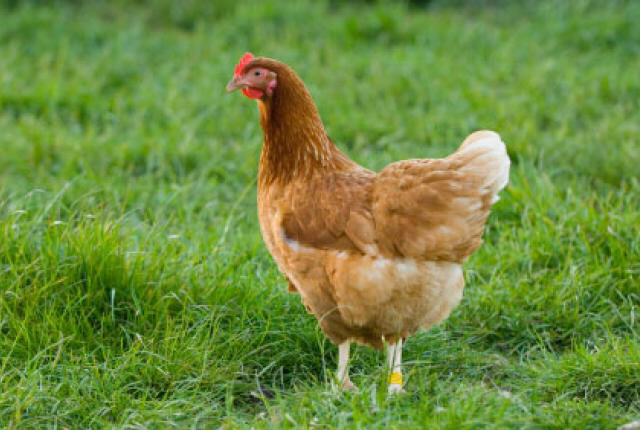

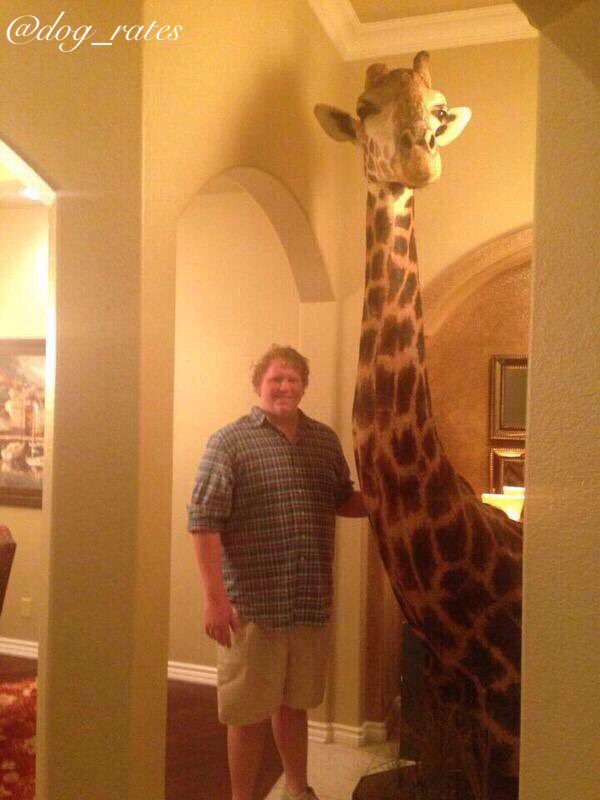

In [29]:
# Explore some of the images to crosscheck the predictions
print(Color.green + Color.bold + 'Collecting two image samples for veiwing..' + Color.end)
for url in no_dog_predicted['jpg_url'].sample(2, random_state=12):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    display(img)

>- In about 324 cases, none of the predictions `p1`, `p2` and `p3` detected a dog breed.
>- The pulled images show that some of the tweets were not actually about dogs. This may explain why the algorithms didn't detect a dog in the first place.
   
#### 3. JSON Tweet Info Data

In [30]:
# Examine a summary of Jsno_tweet_info
json_tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2324 non-null   object
 1   hashtag   2324 non-null   object
 2   retweets  2324 non-null   int64 
 3   likes     2324 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 72.8+ KB


>- 2324 records present. 32 entries lesser than the `wrd_archive` (2356 entries). Majority of these missing records were caused by `Tweepy` errors (from deleted tweets) during the gathering process.

In [31]:
# Check the unique records in the dataframe columns.
for col in json_tweet_info.columns[1:]:
    print(Color.bold+'\nValue counts for {} column'.format(col)+Color.end)
    print(json_tweet_info[col].value_counts())


Value counts for hashtag column
None                               2297
[#BarkWeek]                           9
[#PrideMonth]                         3
[#WKCDogShow]                         1
[#notallpuppers]                      1
[#LoveTwitter]                        1
[#FinalFur]                           1
[#ImWithThor]                         1
[#WomensMarch]                        1
[#BellLetsTalk]                       1
[#GoodDogs]                           1
[#K9VeteransDay]                      1
[#ScienceMarch]                       1
[#dogsatpollingstations]              1
[#PrideMonthPuppo, #PrideMonth]       1
[#Canada150]                          1
[#BATP]                               1
[#NoDaysOff, #swole]                  1
Name: hashtag, dtype: int64

Value counts for retweets column
328      6
459      5
182      5
50       5
798      4
        ..
2469     1
141      1
2341     1
14768    1
707      1
Name: retweets, Length: 1635, dtype: int64

Value counts for lik

>- When present, `hashtags` are stored as lists instead of as python strings.
>- Some tweets are associated with mutiple hashtags.

In [32]:
# Check for the common columns accross the three dataframes.
np.intersect1d(np.intersect1d(wrd_archive.columns, img_predictions.columns),
               json_tweet_info.columns)

array(['tweet_id'], dtype=object)

>- The `tweet_id` column is the only common column accross the three datasets.
   
## Assessment Summary
---
The section below summarizes the findings from both visual and programmatic assessments of the datasets.
### 1. Data Quality
**`wrd_archive`** 
- 181 records are retweets and 78 records are replies to previously created tweets. We won't be needing these records in our analysis.
- `tweet_id` is stored with the wrong datatype. Should be a `string/object` type.
- The `timestamp` column is stored as a `string/object` type rather than Pandas `datetime` type.
- Unusual dog names with improper capitalizations; `a`, `an`, `not`, `very`, `infuriating` etc. These names constitute 109 records.
- Missing records in the `expanded_url` column, the majority being retweets and replies.
- Unexpected values in the `rating_numerator` and `rating_denominator` columns, with numerators as high as 1776 and denominators as low as 0.
    - Some of these unsual ratings were incorrectly extracted from tweet text containing dates or decimals. These ratings can be fixed since we have the correct values included in the text.
    - Some high ratings were allocated to groups of dogs rather than one.
    - Unrealistic high ratings like `1776/10` and `420/10`.
- The `expanded_url` column sometimes contains more than one link, seperated by commas, all leading to the same page.
  
**`img_predictions`**
- `tweet_id` is stored with the wrong datatype. Should be a `string/object` type.
- Columns `p1`, `p2` and `p3` are not uniformly formatted. Some entries are lowercase, some are uppercase and some are titlecase.
    - These predictions also have words seperated by underscores instead of spaces.
- 2075 records are present in `wrd_archive`. This means we have 281 missing records, when compared to the 2356 records in `wrd_archive`.
- Not all predictions in `p1`, `p2`, and `p3` are dog breeds.
   
**`json_tweet_info`**
- 2324 records present. 32 entries lesser than the `wrd_archive` (2356 entries); the majority caused by `Tweepy` errors (from deleted tweets) during the gathering process.
- When present, `hashtags` are stored as lists instead of as python strings.
   
### 2. Data Tidiness
**`wrd_archive`**
- Unwanted columns present: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`.
- The `text` column contains both tweet url and tweet text.
- Long and unneccessary information in the `source` column, with html tags and text present. We only need the device that users are tweeting from.
- The `rating_numerator` and `rating_denominator` can be reduced to one column.
- The various stages of dog life: `doggo`, `pupper`, `puppo`, and `floofer` are contained in seperate columns.

**`img_predictions`**
- The different predictions and their respective confidence level columns can be reduced into two columns to contain `prediction` and `confidence` variables.
- `p1_dog`, `p2_dog` and `p3_dog` columns can be used to select the appropriate predictions to be used, then removed from our dataframe.
- We wont be needing the `img_num` column.

**`json_tweet_info`**
- Rather than standing alone, this dataframe should be merged into `wrd_archive`.
   
## Cleaning Data
---

In [33]:
# Create copies of the original dataframes
archive_clean = wrd_archive.copy()
predictions_clean = img_predictions.copy()
json_clean = json_tweet_info.copy()

### 1a. wrd_archive (Quality Issues)
- **181 records are retweets and 78 records are replies to previously created tweets.**
    
#### Define:
>- From `archive_clean`, drop records where `retweeted_status_id` and `in_reply_to_status_id` are not null.
    
#### Code:

In [34]:
# Filter out retweets and replies using a boolean mask
retweet_reply_mask = archive_clean.retweeted_status_id.notnull() | archive_clean.in_reply_to_status_id.notnull()
archive_clean = archive_clean[~retweet_reply_mask]

#### Test:

In [35]:
# Verify the absence of entries for the retweet and reply columns
assert archive_clean.retweeted_status_id.isnull().all()
assert archive_clean.in_reply_to_status_id.isnull().all()
print('archive_clean has reduced to {:,} records.'.format(archive_clean.shape[0]))

archive_clean has reduced to 2,097 records.


---
- **`tweet_id` is stored with the wrong datatype.**<br>
- **The `timestamp` column is stored as a string/object type rather than Pandas datetime type.**
    
#### Define:
>- convert the `tweet_id` column to `object/string` type and the `timestamp` column to a Pandas `datetime` object.
    
#### Code:

In [36]:
# Convert tweet_ids to string datatype
archive_clean['tweet_id'] = archive_clean['tweet_id'].astype(str)
# Convert timestamp to a pandas datetime object
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

#### Test:

In [37]:
archive_clean[['tweet_id', 'timestamp']].dtypes

tweet_id                  object
timestamp    datetime64[ns, UTC]
dtype: object

---
- **Unusual dog names with improper capitalizations; `a`, `an`, `not`, `very`, `infuriating` etc.**
    
#### Define:
>- Replace unusual names having improper capitalizations with `None`.
    
#### Code:


In [38]:
# Create a boolean mask to identify the unusual names
unusual_names_mask = archive_clean['name'].str.match(r"[a-z].?")
# Identify each unique unusual name from the name column
unusual_names = archive_clean['name'][unusual_names_mask].unique()
# Replace all unusual names with None
archive_clean['name'] = archive_clean['name'].apply(lambda n: 'None' if n in unusual_names else n)

#### Test:

In [39]:
# Verify if there are any improper names still present
assert archive_clean['name'].str.match(r"[a-z].?").sum() == 0

---
- **Missing records in the `expanded_urls` column, the majority being retweets and replies.**<br>
- **The `expanded_url` column sometimes contains more than one link, seperated by commas, all leading to the same page.**
    
#### Define:
>- Drop the `expanded_url` column since the urls are already present in the tweet text. Having multiple links leading to the same page is redundant. We will split the text column into two columns later.
    
#### Code:


In [40]:
# Drop the expanded urls from archive clean
archive_clean.drop(columns='expanded_urls', inplace = True)

#### Test:

In [41]:
# Check if the expanded urls column is now absent from the dataframe
assert 'expanded_urls' not in archive_clean.columns

---
- **Unexpected values in the `rating_numerator` and `rating_denominator columns`, with numerators as high as `1776` and denominators as low as `0`.**<br>
    - Some of these unsual ratings were incorrectly extracted from tweet text containing dates or decimals.
    - Some high ratings were allocated to groups of dogs rather than one.
    - Unrealistic high ratings like `1776/10` and `420/10`.
   
#### Define:
The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs. However, we will:
>- Remove the records with the overly high ratings of `420/10` and `1776/10`.
>- Remove the record with rating of `24/7`. This is a date, not an actual rating; the right rating is absent from the text.
>- Programmatically extract the right ratings from text to replace the wrong ones.
>- Convert high ratings allocated to dog groups to a scale of 10. _This will be done later, when tidying up the dataframe_.
    
#### Code:


In [42]:
# Filter out records with unwanted ratings: 420/10, 1776/10 and 24/7
for num, denum in zip([420, 1776, 24], [10, 10, 7]):
    mask = (archive_clean['rating_numerator'] == num) & (archive_clean['rating_denominator'] == denum)
    archive_clean = archive_clean[~mask]

In [43]:
# Isolate unusual ratings: numerator > 15 and denominator not equal to 10
unusual_rating_mask = (archive_clean['rating_numerator'] > 15) | (archive_clean['rating_denominator']!=10)
unusual_ratings = archive_clean[unusual_rating_mask].copy()

# Replace the numerator and denominators with the right values, if present in the tweet text
pattern = r"([0-9\.]+/[0-9]+)"
unusual_ratings[['rating_numerator', 'rating_denominator']] = (unusual_ratings['text']
                                                               .str.findall(pattern)
                                                               .str[-1]
                                                               .str.split('/', expand=True)
                                                              )

In [44]:
# Streamline the result down to the relevant columns
cleaned_ratings = unusual_ratings[['text', 'rating_numerator', 'rating_denominator']]
# Update the ratings in archive clean with the cleaned ratings
archive_clean.update(cleaned_ratings)

#### Test:

In [45]:
# Verify the removal of the unwanted ratings.
for rating_num in [420, 24, 1776]:
    assert rating_num not in archive_clean.rating_numerator.unique()
# Verify the records with unusual ratings
archive_clean[unusual_rating_mask][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://...,11.27,10
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,13,10
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80


---
### 1b. wrd_archive (Tidiness Issues)
- **Unwanted columns present: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`.**
    
#### Define:
>- Drop the unwanted columns from the `archive_clean` dataframe.
    
#### Code:

In [46]:
# Drop unwanted columns from archive clean
unwanted_cols = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp']
archive_clean.drop(columns=unwanted_cols, inplace=True)

#### Test:

In [47]:
# Verify that the unwanted columns have been dropped
for col in unwanted_cols:
    assert col not in archive_clean.columns

---
- **The `text` column contains both tweet url and tweet text.**
    
#### Define:
>- Extract the tweet url into a seperate column.
>- Remove tweet urls from tweet text.
    
#### Code:

In [48]:
# Create a pattern to extract urls
pattern = r"(http.+)"
# Extract urls into a tweet url column
archive_clean['tweet_url'] = archive_clean['text'].str.extract(pattern)
# Account for records where tweet text does not contain a url
archive_clean['tweet_url'].fillna('None', inplace = True)
# Remove urls from the text column
archive_clean['text'] = archive_clean['text'].str.replace(pattern, '', regex=True)

#### Test:

In [49]:
archive_clean[['text', 'tweet_url']].sample(5)

,text,tweet_url
791,This is Loki. He knows he's adorable. One ear always pupared. 12/10 would snug in depicted fashion forever,https://t.co/OqNggd4Oio
812,This is Dixie. She wants to be a ship captain. Won't let anything get in between her and her dreams. 11/10,https://t.co/8VEDZKHddR
2052,This is Malcolm. He just saw a spider. 10/10,https://t.co/ympkwF65Dx
57,Meet Elliot. He's a Canadian Forrest Pup. Unusual number of antlers for a dog. Sneaky tongue slip to celebrate #Canada150. 12/10 would pet,https://t.co/cgwJwowTMC
385,This is Cupid. He was found in the trash. Now he's well on his way to prosthetic front legs and a long happy doggo life. 13/10 heroic af,https://t.co/WS0Gha8vRh


---
- **Long and unneccessary information in the `source` column, with html tags and text present. We only need the device that users are tweeting from.**
    
#### Define:
>- Extract the device information from the `source` column.
    
#### Code:

In [50]:
# Create a pattern to extract info between the <a></a> tags
pattern = r">(.+)<"
# Extract information using the defined pattern
archive_clean['source'] = archive_clean['source'].str.extract(pattern)

#### Test:

In [51]:
# Verify the extraction process
archive_clean.source.value_counts()

Twitter for iPhone     1962
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                10
Name: source, dtype: int64

---
- **The `rating_numerator` and `rating_denominator` can be reduced to one column.**
    
#### Define:
>- Convert all ratings to a denominator scale of `10` using the expression:  $rating = \frac{rating\,numerator}{rating\,denominator} \times 10 $. With this expression, a rating of `120/100` becomes `12/10` and a rating of `55/60` becomes `9.16/10`.
>- Once the ratings are standardized, reduce ratings to a single column called `rating`.
>- Drop the `rating_numerator` and `rating_denominator` columns.
    
#### Code:


In [52]:
# Use the expression to calculate a single rating value
rating = 10 * (archive_clean['rating_numerator'].astype(float) / archive_clean['rating_denominator'].astype(float))
# Allocate the values into a new column in archive_clean
archive_clean['rating'] = rating
# Drop the rating numerator and denominator columns
archive_clean.drop(columns=['rating_numerator', 'rating_denominator'], inplace=True)

#### Test:

In [53]:
# Check how standardized ratings are now distributed in dataframe
archive_clean.rating.describe()

count    2094.000000
mean       10.610926
std         2.147757
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating, dtype: float64

In [54]:
# Verify the rating in the tweet text where the rating is equal to zero
print(Color.bold+'Verifying the text in records where rating is zero...'+Color.end)
print(archive_clean.loc[archive_clean.rating==0, 'text'])

# verify the absence of the dropped columns
for col in 'rating_numerator', 'rating_denominator':
    assert col not in archive_clean.columns

Verifying the text in records where rating is zero...
315    When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 
Name: text, dtype: object


---
- **The various stages of dog life: `doggo`, `pupper`, `puppo`, and `floofer` are contained in seperate columns.**
    
#### Define:
>- Check and correct for conflicting dog stages, if present.
>- Store all the dog stages in a single column called `stage`.
>- Drop the columns `doggo`, `pupper`, `puppo`, and `floofer`.
>- Convert the `stage` column to a categorical type
    
#### Code:

In [55]:
# Isolate the dog stage columns into a dataframe
stage_df = archive_clean[['doggo', 'pupper', 'puppo', 'floofer']]
# Check if there are situations where multiple stages co-exist
stage = stage_df.sum(axis=1)
stage.value_counts()

NoneNoneNoneNone        1758
NonepupperNoneNone       221
doggoNoneNoneNone         72
NoneNonepuppoNone         23
NoneNoneNonefloofer        9
doggopupperNoneNone        9
doggoNonepuppoNone         1
doggoNoneNonefloofer       1
dtype: int64

_It seems that some records actually present with multiple dog stages. This is hard to read through for now, so we will trim off the extra `None` characters._

In [56]:
# Remove None from the each entry, unless the string the string is made up of only Nones
stage = stage.apply(lambda x: x.replace('None', '') if x.replace('None', '') != '' else 'None')
stage.value_counts()

None            1758
pupper           221
doggo             72
puppo             23
floofer            9
doggopupper        9
doggopuppo         1
doggofloofer       1
dtype: int64

_`11` records have dogs classified as a mix of doggo and some other stages. To be sure this was not done in error, we can examine the tweet text in detail. These records are few, so we can manually identify and correct them:_

In [57]:
# Assign the dog stages into a column in archive_clean
archive_clean['stage'] = stage
# Identify records where dogs were assigned multiple stages
multiple_stages = ['doggopupper', 'doggopuppo', 'doggofloofer']
multiple_stage_mask = archive_clean.stage.apply(lambda x: x in multiple_stages)
archive_clean[multiple_stage_mask][['tweet_id', 'tweet_url', 'text', 'stage']]

,tweet_id,tweet_url,text,stage
191,855851453814013952,https://t.co/cMhq16isel,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for,doggopuppo
200,854010172552949760,https://t.co/TXdT3tmuYk,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs",doggofloofer
460,817777686764523521,https://t.co/m7isZrOBX7,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo)",doggopupper
531,808106460588765185,https://t.co/ANBpEYHaho,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time,doggopupper
575,801115127852503040,https://t.co/55Dqe0SJNj,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine,doggopupper
705,785639753186217984,https://t.co/f2wmLZTPHd,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously,doggopupper
733,781308096455073793,https://t.co/WQvcPEpH2u,"Pupper butt 1, Doggo 0. Both 12/10",doggopupper
889,759793422261743616,https://t.co/MYwR4DQKll,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time",doggopupper
956,751583847268179968,https://t.co/u2c9c7qSg8,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho,doggopupper
1063,741067306818797568,https://t.co/o5J479bZUC,This is just downright precious af. 12/10 for both pupper and doggo,doggopupper


_After reading through the text and checking the tweet urls, we can obeserve the following:_
- Tweets with id: [808106460588765185](https://t.co/ANBpEYHaho), [781308096455073793](https://t.co/WQvcPEpH2u), [759793422261743616](https://t.co/MYwR4DQKll), [741067306818797568](https://t.co/o5J479bZUC), and [733109485275860992](https://t.co/pG2inLaOda) are actually about two dogs, a doggo and a pupper, hence the doggopupper classification. We will leave them as they are.

- Some dogs were erroneously categorized, but the appropriate dog stage is in the tweet text. The record with `tweet_id`:
    - _[855851453814013952](https://t.co/cMhq16isel) should be puppo._
    - _[854010172552949760](https://t.co/TXdT3tmuYk) should be floofer._
    - _[817777686764523521](https://t.co/m7isZrOBX7) should be pupper._
    - _[801115127852503040](https://t.co/55Dqe0SJNj) should be pupper._
    - _[751583847268179968](https://t.co/u2c9c7qSg8) should be doggo._


- `tweet_id` [785639753186217984](https://t.co/f2wmLZTPHd) is not about a dog. The tweet is actually about a hedgehog. We will remove this record.

In [58]:
# Remove the record about a hedgehog: tweet_id 785639753186217984.
archive_clean = archive_clean.query("tweet_id != '785639753186217984'")

In [59]:
# Correct the erroneously categorized records
correction_dict = {
    '855851453814013952': 'puppo',
    '854010172552949760': 'floofer',
    '817777686764523521': 'pupper',
    '801115127852503040': 'pupper',
    '751583847268179968': 'doggo'
}

for key in correction_dict.keys():
    archive_clean.loc[archive_clean['tweet_id'] == key, 'stage'] = correction_dict[key]

In [60]:
# Drop the columns puppo, doggo, floofer and pupper
archive_clean.drop(columns=['doggo', 'pupper', 'puppo', 'floofer'], inplace=True)
# Convert the stage column to categorical type
archive_clean.stage = archive_clean.stage.astype('category')

#### Test:

In [61]:
# Check if the record with tweet_id 785639753186217984 has been dropped
assert '785639753186217984' not in archive_clean.tweet_id.values
# Check if the unwanted columns have been dropped
assert archive_clean.columns.any() not in ['doggo', 'pupper', 'puppo', 'floofer']
# Verify the datatype in stage
assert archive_clean.stage.dtypes == 'category'
# Verify the values in the dog stage column
archive_clean.stage.value_counts()

None           1758
pupper          223
doggo            73
puppo            24
floofer          10
doggopupper       5
Name: stage, dtype: int64

---
**One more thing! let's format the dog stage entries to title case, then give `doggopupper` a more befitting value.**

In [62]:
# Format dog stage entries to title case
archive_clean.stage = archive_clean.stage.apply(lambda x: x.title() if x !='doggopupper' else 'Doggo with Pupper')
archive_clean.stage.value_counts()

None                 1758
Pupper                223
Doggo                  73
Puppo                  24
Floofer                10
Doggo with Pupper       5
Name: stage, dtype: int64

In [63]:
# Reset the indices of the archive clean dataframe
archive_clean = archive_clean.reset_index(drop=True)
# Preview cleaming results
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   tweet_id   2093 non-null   object             
 1   timestamp  2093 non-null   datetime64[ns, UTC]
 2   source     2093 non-null   object             
 3   text       2093 non-null   object             
 4   name       2093 non-null   object             
 5   tweet_url  2093 non-null   object             
 6   rating     2093 non-null   float64            
 7   stage      2093 non-null   category           
dtypes: category(1), datetime64[ns, UTC](1), float64(1), object(5)
memory usage: 116.8+ KB


---
**Note**: _Some of the tidiness issues in `img_predictions` overlap with quality issues. Solving the tidiness issues first can make cleaning easier later._
### 2a. img_predictions (Tidiness Issues)
- **The different predictions (`p1`, `p2`, `p3`) and their respective confidence level (`p1_conf`, `p2_conf`, `p3_conf`) columns can be reduced into two columns to contain `prediction` and `confidence` variables.**
- **`p1_dog`, `p2_dog` and `p3_dog` columns can be used to select the appropriate predictions to be used.**
- **We wont be needing the `img_num` column.**

#### Define:
Part A
>- Iterate through each row of `predictions_clean` and extract the best prediction and confidence values.
>- Assign these values into new columns named `breed` and `confidence`.
    
Part B
>- Drop all unwanted columns: `p1`, `p2`, `p3`, `p1_conf`, `p2_conf`, `p3_conf`, `p1_dog`, `p2_dog`, `p3_dog` and `img_num`.
    
#### Code A:

In [64]:
# Create a list to store the best prediction and confidence values
prediction_list = []

# Define a function to perform the extraction process
def extract_breed_info(row):
    """
        Extracts the best prediction and confidence value from passed row.
        Params:
            row: row from dataframe of interest.
        Output:
            A dictionary containing prediction and confidence appended into prediction list.
            Prints a status update of extraction process.
    """
    if row.p1_dog:
        prediction_list.append({'breed': row.p1,'confidence': row.p1_conf})
    elif row.p2_dog:
        prediction_list.append({'breed': row.p2,'confidence': row.p2_conf})
    elif row.p3_dog:
        prediction_list.append({'breed': row.p3,'confidence': row.p3_conf})
    else:
        prediction_list.append({'breed': 'Unknown','confidence': 0})
    return 'Info extracted to prediction list'

In [65]:
# Run the extraction process
predictions_clean.apply(extract_breed_info, axis=1)

0       Info extracted to prediction list
1       Info extracted to prediction list
2       Info extracted to prediction list
3       Info extracted to prediction list
4       Info extracted to prediction list
                      ...                
2070    Info extracted to prediction list
2071    Info extracted to prediction list
2072    Info extracted to prediction list
2073    Info extracted to prediction list
2074    Info extracted to prediction list
Length: 2075, dtype: object

In [66]:
# Assign the values in prediction list into new columns in predictions_clean
predictions_clean[['breed', 'confidence']] = pd.DataFrame(prediction_list)
# Round confidence to three decimal places
predictions_clean.confidence = round(predictions_clean.confidence, 3)

#### Test A:

In [67]:
# Verify the extraction process
predictions_clean.iloc[:, 3:].sample(5)

,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,confidence
112,frilled_lizard,0.257695,False,ox,0.235160,False,triceratops,0.085317,False,Unknown,0.000
1489,malamute,0.840871,True,Tibetan_mastiff,0.140516,True,Eskimo_dog,0.012012,True,malamute,0.841
16,English_setter,0.298617,True,Newfoundland,0.149842,True,borzoi,0.133649,True,English_setter,0.299
724,Great_Dane,0.236920,True,Irish_wolfhound,0.117608,True,Greater_Swiss_Mountain_dog,0.103900,True,Great_Dane,0.237
1646,Airedale,0.454239,True,cocker_spaniel,0.219323,True,Irish_terrier,0.093193,True,Airedale,0.454


#### Code B:

In [68]:
# Create a list of unwanted columns
unwanted_columns = ['p1','p2', 'p3','p1_conf', 'p2_conf', 'p3_conf','p1_dog', 'p2_dog', 'p3_dog', 'img_num']
# Drop all unwanted columns
predictions_clean.drop(columns=unwanted_columns, inplace=True)

#### Test B:

In [69]:
assert predictions_clean.columns.any() not in unwanted_columns

---
### 2b. img_predictions (Quality Issues)
- **`tweet_id` is stored with the wrong datatype. Should be a `string/object` type.**

#### Define:
>- Convert `tweet_id` column to `string/object`
    
#### Code:


In [70]:
# Convert tweet_ids to string datatype
predictions_clean['tweet_id'] = predictions_clean['tweet_id'].astype(str)

#### Test:

In [71]:
# Verify the datatype for tweet_id
assert predictions_clean['tweet_id'].dtypes == 'O'

---
- **Columns `p1`, `p2` and `p3` are not uniformly formatted. Some entries are lowercase, some are uppercase and some are titlecase**.
    - **These predictions also have words seperated by underscores and instead of spaces.**

#### Define:
>- Perform cleaning on the `prediction` column, since `p1`, `p2` and `p3` have been removed.
>- Replace underscores with spaces and format all entries to titlecase.
    
#### Code:

In [72]:
# Remove all underscores and format the breed text to titlecase.
predictions_clean.breed = predictions_clean.breed.str.replace('_', ' ').str.title()

#### Test:

In [73]:
predictions_clean.breed.unique()

array(['Welsh Springer Spaniel', 'Redbone', 'German Shepherd',
       'Rhodesian Ridgeback', 'Miniature Pinscher',
       'Bernese Mountain Dog', 'Unknown', 'Chow', 'Golden Retriever',
       'Miniature Poodle', 'Gordon Setter', 'Walker Hound', 'Pug',
       'Bloodhound', 'Lhasa', 'English Setter', 'Italian Greyhound',
       'Maltese Dog', 'Newfoundland', 'Malamute',
       'Soft-Coated Wheaten Terrier', 'Chihuahua',
       'Black-And-Tan Coonhound', 'Toy Terrier', 'Blenheim Spaniel',
       'Pembroke', 'Irish Terrier', 'Chesapeake Bay Retriever',
       'Curly-Coated Retriever', 'Dalmatian', 'Ibizan Hound',
       'Border Collie', 'Labrador Retriever', 'Miniature Schnauzer',
       'Airedale', 'Rottweiler', 'West Highland White Terrier',
       'Toy Poodle', 'Giant Schnauzer', 'Vizsla', 'Siberian Husky',
       'Papillon', 'Saint Bernard', 'Tibetan Terrier', 'Borzoi', 'Beagle',
       'Yorkshire Terrier', 'Pomeranian', 'Kuvasz',
       'Flat-Coated Retriever', 'Norwegian Elkhound', '

_**Note:** We will not clean entries with dashes `(-)` since their use is grammatically correct in this case._<br>

---
- **Not all predictions in `p1`, `p2`, and `p3` are dog breeds.**
    
#### Define:

>- This has been addressed in the process of tidying up the data.
>- Predictions that are not dog breeds have been assigned a value of `Unknown`.
   
#### Test:

In [74]:
# Verify the presence of records tagged unknown
predictions_clean.breed.value_counts().head()

Unknown               324
Golden Retriever      173
Labrador Retriever    113
Pembroke               96
Chihuahua              95
Name: breed, dtype: int64

---
- **2075 records are present in `wrd_archive`. This means we have 281 missing records, when compared to the 2356 records in `wrd_archive`.**
    
#### Define:

>- We can account for this by merging `archive_clean` and `predictions_info` with an `inner join`. This way, only records common to both dataframes will be retained.
>- We will do this after cleaning the `json_clean` dataframe.
   
---
### 3a. json_tweet_info (Quality Issues)
- **When present, hashtags are stored as lists instead of as python strings.**

#### Define:
>- Transform each hashtag from the tweet into a distinct record by exploding the dataframe.
    
#### Code:

In [75]:
# Transform each element in the hashtag list to a distinct row in the dataframe
json_clean = json_clean.explode('hashtag')

#### Test:

In [76]:
json_clean.hashtag.value_counts()

None                      2297
#BarkWeek                    9
#PrideMonth                  4
#BellLetsTalk                1
#NoDaysOff                   1
#notallpuppers               1
#LoveTwitter                 1
#FinalFur                    1
#ImWithThor                  1
#WomensMarch                 1
#GoodDogs                    1
#WKCDogShow                  1
#K9VeteransDay               1
#ScienceMarch                1
#dogsatpollingstations       1
#PrideMonthPuppo             1
#Canada150                   1
#BATP                        1
#swole                       1
Name: hashtag, dtype: int64

---
### 3b. json_tweet_info (Tidiness Issues)
- **Rather than standing alone, this dataframe should be merged into `wrd_archive`**.
  
#### Define:
>- We can resolve this by merging the json_clean dataframe into archive_clean.
    
**Note:** We will create a master dataset by merging all the cleaned dataframes with an inner join. In addition to the issue listed above, this merge will help us address the following pending issues:
- `json_tweet_info (Quality issue)`: 2324 records present. 32 entries lesser than the `wrd_archive` (2356 entries); the majority caused by `Tweepy` errors (from deleted tweets) during the gathering process.
- `img_predictions (Quality issue)`: 2075 records are present in wrd_archive. This means we have 281 missing records, when compared to the 2356 records in wrd_archive.
   
### Creating a Master Dataset
---

In [77]:
# reset dataframe indices for json_clean and predictions_clean
json_clean = json_clean.reset_index(drop=True)
predictions_clean = predictions_clean.reset_index(drop=True)

In [78]:
# Merge archive clean and prediction clean into master df
master_df = pd.merge(archive_clean, predictions_clean, on='tweet_id', how='inner')
# Merge json clean into master df
master_df = pd.merge(master_df, json_clean, on='tweet_id', how='inner')
# Check results 
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1958 entries, 0 to 1957
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweet_id    1958 non-null   object             
 1   timestamp   1958 non-null   datetime64[ns, UTC]
 2   source      1958 non-null   object             
 3   text        1958 non-null   object             
 4   name        1958 non-null   object             
 5   tweet_url   1958 non-null   object             
 6   rating      1958 non-null   float64            
 7   stage       1958 non-null   category           
 8   jpg_url     1958 non-null   object             
 9   breed       1958 non-null   object             
 10  confidence  1958 non-null   float64            
 11  hashtag     1958 non-null   object             
 12  retweets    1958 non-null   int64              
 13  likes       1958 non-null   int64              
dtypes: category(1), datetime64[ns, UTC](1), 

#### Notes:
   
>- We can reorder the columns in a much more intuituve pattern.
>- We should assign a more descriptive name to columns like `name`, `breed`, `stage`, and `jpg_url`.
    
Lets add these finishing touches to our master dataframe:

In [79]:
# Order the columns in master df
column_order = ['tweet_id', 'timestamp', 'name', 'breed', 'confidence', 'stage', 'rating',
                'hashtag', 'retweets', 'likes', 'jpg_url', 'tweet_url', 'text']
master_df = master_df[column_order]

# Give the columns descriptive names
master_df.rename(columns={
    'name': 'dog_name',
    'breed': 'dog_breed',
    'stage': 'dog_stage',
    'jpg_url': 'image'
}, inplace=True)

In [80]:
# Preview some information from master_df
master_df.info()
master_df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1958 entries, 0 to 1957
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweet_id    1958 non-null   object             
 1   timestamp   1958 non-null   datetime64[ns, UTC]
 2   dog_name    1958 non-null   object             
 3   dog_breed   1958 non-null   object             
 4   confidence  1958 non-null   float64            
 5   dog_stage   1958 non-null   category           
 6   rating      1958 non-null   float64            
 7   hashtag     1958 non-null   object             
 8   retweets    1958 non-null   int64              
 9   likes       1958 non-null   int64              
 10  image       1958 non-null   object             
 11  tweet_url   1958 non-null   object             
 12  text        1958 non-null   object             
dtypes: category(1), datetime64[ns, UTC](1), float64(2), int64(2), object(7)
memory usage: 201.0+ 

,tweet_id,timestamp,dog_name,dog_breed,confidence,dog_stage,rating,hashtag,retweets,likes,image,tweet_url,text
0,892420643555336193,2017-08-01 16:23:56+00:00,Phineas,Unknown,0.0,None,13.0,None,7024,33866,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,https://t.co/MgUWQ76dJU,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10


## Storing Data
---
Let's store our `master_df` locally into a new file named `twitter_archive_master.csv`

In [81]:
# Store master_df locally
master_df.to_csv('./twitter_archive_master.csv', index=False, encoding='utf-8')
# Verify storage process
print(Color.green+Color.bold+'Printing csv file list in local directory...'+Color.end)
!ls -lh *.csv

Printing csv file list in local directory...
-rw-r--r--@ 1 israelogunmola  staff   894K Jun  1 19:56 twitter-archive-enhanced.csv
-rw-r--r--  1 israelogunmola  staff   513K Jun 12 22:35 twitter_archive_master.csv


## Analyzing and Visualizing Data
---
Our analysis will focus on exploring the data to understand the following:
- The most popular dog breeds tweeted by WeRateDogs.
- The highest rated breeds on average.
- Activity on the WeRateDogs twitter account within the time period. This will be assessed in terms of the total tweets posted overtime.
- User engagement, as it relates to posts created on the account.
- How users interact with tweets that relate to the various dog stages (puppo, pupper, doggo etc.).
- Hashtags and how they relate to user engagement.
- The association, if any, between retweets and likes.

User engagement will be assessed in terms of retweets and likes.
### 1. What are the top breeds in terms of popularity?
#### Logic:
>- Filter out records with for which we don't have a dog breed.
>- Consider the top 20 breeds in terms of the number of tweets posted.
>- Visualize this information using a bar graph.
   
#### Action:

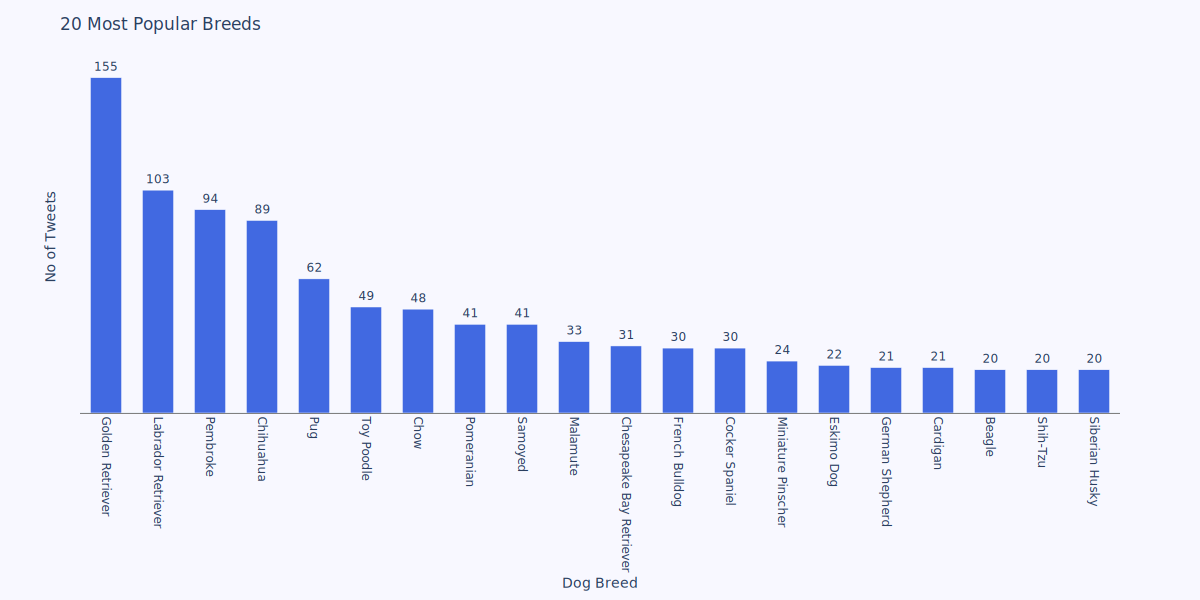

In [82]:
# Remove records with unknown breeds
known_breeds_df = master_df.query("dog_breed != 'Unknown'")

# Isolate the 20 most popular breeds and their tweet counts
popular_20 = known_breeds_df.dog_breed.value_counts().head(20)

# Create a visual
fig = px.bar(x=popular_20.index, y=popular_20.values, text=popular_20.values, height=600, width=1200, template='plotly_white')
fig.update_xaxes(tickangle=90, linecolor='grey')
fig.update_yaxes(showgrid=False, showticklabels=False)
fig.update_traces(width=0.6, textposition='outside', marker_color='royalblue')
fig.update_layout(
    yaxis_title='No of Tweets', 
    xaxis_title='Dog Breed',
    title='20 Most Popular Breeds<br><sup>Popular breeds ranked by number of tweets between Nov 2015 to Jul 2017.</sup>',
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    font_family='Sathu'
)

fig.show('svg')

#### Findings:
>- The **Golden retriever** is the most popular breed, having a total count of 155 tweets. The **Labrador retriever** follows behind with 103 tweets. In total, the two retrievers (golden and labrador) contributed to 258 tweets.
>- Other notable breeds include the **Pembroke**, **Chihuahua** and the **Pug**, occupying the 3rd to 5th place respectivitly.
   
---
### 2. In terms of rating, what are the top 20 breeds, especially when compared to the list of popular dog breeds?
#### Logic:
>- Filter out records for which we don't have a dog breed.
>- Filter out breeds with less than 10 tweets, since we are considering popularity also.
>- Compute average ratings for each breed and select the top 20.
>- Visualize results.

#### Action:

In [83]:
# Known_breeds_df already filters out unknown breeds

# Identify the number of breeds with less than 10 tweets
breed_tweet_count = known_breeds_df.dog_breed.value_counts()
print('There are {} breeds with less than 10 tweets'.format((breed_tweet_count >= 10).sum()))

There are 53 breeds with less than 10 tweets


In [84]:
# Get the names of breeds with more than 10 tweets
wanted_breeds = breed_tweet_count[breed_tweet_count >=10].index

# Select the right breeds from the dataframe
wanted_breed_ratings = master_df[master_df.dog_breed.apply(lambda x: x in wanted_breeds)][['dog_breed', 'rating']]

# Compute average rating per breed, then select the top 20
top_20_rated = wanted_breed_ratings.groupby('dog_breed').mean().sort_values(by='rating').tail(20)

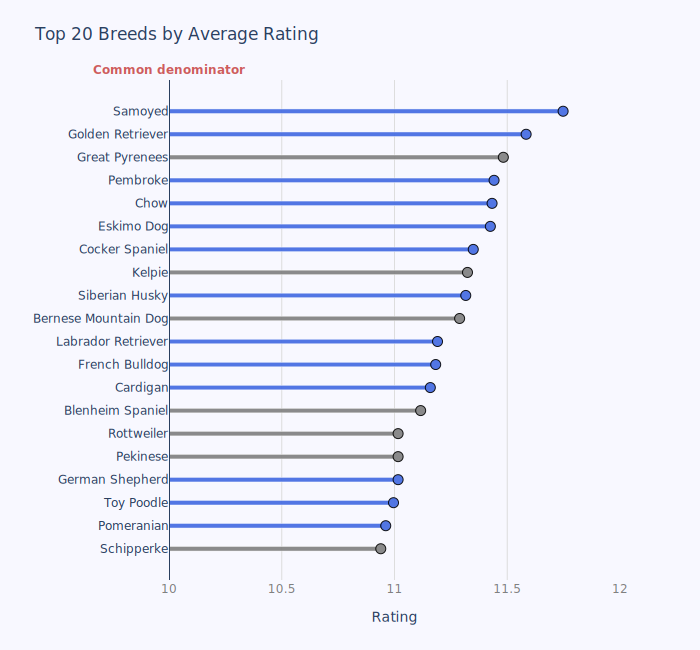

In [85]:
# --- Visualize results ---

# Create a color map to identify breeds in the popular 20 list
color_map = top_20_rated.reset_index()['dog_breed'].apply(lambda x: x in popular_20.index)

# Create plot area and add traces
fig = go.Figure()
fig.add_trace(go.Bar(y=top_20_rated.index, x=top_20_rated.rating, orientation='h'))
fig.add_trace(go.Scatter(y=top_20_rated.index, x=top_20_rated.rating+0.016, mode='markers', marker_size=10))

# --- Set trace properties ---
# Set trace properties for bar plot
fig.update_traces(width=0.2, selector=dict(type="bar"))

# Set trace properties for scatter plot
fig.update_traces(textposition='middle right', selector=dict(type="scatter"), 
                 marker_line_color='black', marker_line_width=1)

#Set trace properties common to both plots
fig.update_traces(marker=dict(color=color_map.astype(int), colorscale=[[0, '#7F7F7F'], [1, 'royalBlue']],
                             opacity=0.9))

# Update axes and plot layout
fig.update_yaxes(ticksuffix='  ', tickfont=dict(size=12))
fig.update_xaxes(showgrid=True, gridcolor='#ddd', showticklabels=True, range=[10, 12], tickfont_color='grey')

fig.update_layout(xaxis_title='Rating', yaxis_title='', font_family='Sathu',
                  width=700, height=650, margin=dict(t=80, b=70),
                  template='plotly_white', showlegend=False,
                  title = 'Top 20 Breeds by Average Rating<br><sup>The blue bars represent breeds '+
                  'that are also present on the popular 20 list.</sup>',
                  paper_bgcolor='rgb(248, 248, 255)', plot_bgcolor='rgb(248, 248, 255)'
)

# Add annotations
fig.add_vline(x=10, annotation=dict(text='<b>Common denominator</b>'), annotation_position='top', annotation_font_color='IndianRed')

fig.show('svg')

#### Findings:
>- The **Samoyed**, **Golden retriever**, **Great Pyrenees**, **Pembroke** and **Chow** are the top five breeds in terms of average ratings.
>- 13 of the top rated breeds (13/20) are also present on the most popular list. It appears that these breeds enjoy in both rating and popularity.
    
---
### 3. What dog stage do users favor the most?
#### Logic:
>- Identify and filter out records where a dog stage was not mentioned.
>- Isolate only the proper dog stages (doggo, puppo and pupper). The floofer isn't an ideal dog stage since any of the other dog stages can be a floofer too.
>- Compute the average retweets, likes and ratings by dog stage.
>- Remove records with two stages in one tweet e.g a doggo and a pupper. It will be hard to tell the one that users liked. 
>- Melt the resulting dataframe; for ease of plotting with Plotly.
>- Visualize results.
   
#### Action:

In [86]:
# First estimate the fraction of total records where dog stage was mentioned
stage_counts = master_df.dog_stage.value_counts()
print('Only {} records mentioned the stage of the dog'.format(stage_counts.drop('None').sum()))

Only 301 records mentioned the stage of the dog


In [87]:
# Compute the mean retweets, likes and ratings for each dog stage
stage_aggregates = master_df.groupby('dog_stage')[['retweets', 'likes', 'rating']].mean()

# Remove records with None, Floofer and Doggo with Pupper
stage_aggregates.drop(index = ['None', 'Floofer', 'Doggo with Pupper'], inplace=True)

# Melt the dataframe for plotting ease
stage_aggregates = stage_aggregates.reset_index().melt(id_vars='dog_stage', var_name='criteria', value_name='mean')
stage_aggregates

,dog_stage,criteria,mean
0,Doggo,retweets,5906.793651
1,Pupper,retweets,1936.712871
2,Puppo,retweets,5708.541667
3,Doggo,likes,17412.269841
4,Pupper,likes,6306.376238
5,Puppo,likes,20427.583333
6,Doggo,rating,11.761905
7,Pupper,rating,10.644901
8,Puppo,rating,12.083333


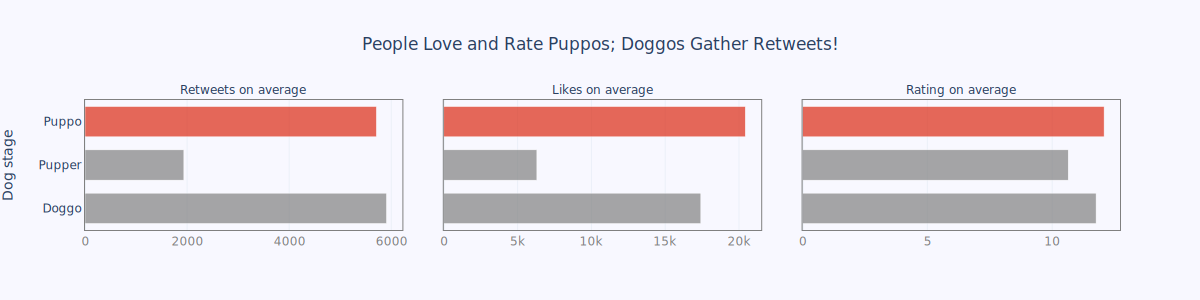

In [88]:
# --- Visualize results ---

# Create main plot area
fig = px.bar(stage_aggregates, y='dog_stage', x = 'mean', orientation='h', facet_col='criteria', template='plotly_white',
            height=300, width=1200, facet_col_spacing=0.04)

# Customize traces and annotations
fig.update_traces(width=0.7, marker_color=['grey', 'grey', '#DC2912'], opacity=0.7)
fig.for_each_annotation(lambda a: a.update(text= a.text.split("=")[-1].title() + ' on average'))

# Update axes and plot layout
fig.update_xaxes(matches=None, showline=True, linewidth=1, linecolor='grey', mirror=True, 
                 titlefont_size=12, tickfont_color='grey')
fig.update_yaxes(ticksuffix='  ', showline=True, linewidth=1, linecolor='grey', mirror=True)

fig.update_layout(yaxis_title='Dog stage', xaxis_title='', xaxis2_title='', xaxis3_title='',
                  paper_bgcolor='rgb(248, 248, 255)', plot_bgcolor='rgb(248, 248, 255)',
                  title='People Love and Rate Puppos; Doggos Gather Retweets!<br>'+
                  '<sup>User retweets, likes and ratings compared across various dog stages.</sup>',
                  title_x=0.5, font_family='Sathu',
                  margin=dict(t=100, b=70))

fig.show('svg')

#### Findings:
>- Puppos seem to be the people favorite, leading in average likes (over 20,000) and ratings (12). Doggo tweets also show good engagements in terms of likes (17,412) and ratings (11.7).
>- Doggo tweets are marginally retweeted more than Puppo tweets on average (5,906 retweets vs 5,708 retweets).
>- Pupper tweets considerably gather the least retweets, likes and ratings.
   
---
### 4. Are Hashtags associated with higher tweet engagements?
#### Logic:
>- Identify the number of records that had hashtags included in the tweet. This helps understand if we have enough data to make conclusions.
>- Compute the average retweets, likes and ratings by hashtag use.

#### Action:

In [89]:
# Select only relevant columns from the master dataframe
hashtag_df = master_df[['hashtag', 'likes', 'retweets', 'rating']].copy()

# Create a new column to show if hashtags are present in each record
hashtag_df['has_hashtag'] = hashtag_df.hashtag.apply(lambda x: x!='None')

print(Color.green+'Printing the number of records based on hashtag use...'+Color.end)
print(hashtag_df.has_hashtag.value_counts(), '\n')

print(Color.green+'Printing the percentage of records based on hashtag use...'+Color.end)
(hashtag_df.has_hashtag.value_counts(normalize=True).round(3)*100).astype(str)+'%'

Printing the number of records based on hashtag use...
False    1934
True       24
Name: has_hashtag, dtype: int64 

Printing the percentage of records based on hashtag use...


False    98.8%
True      1.2%
Name: has_hashtag, dtype: object

In [90]:
# Aggregate ratings, retweets and likes by hashtag use
hashtag_df.groupby('has_hashtag')[['retweets', 'likes', 'rating']].mean().astype(int)

,retweets,likes,rating
has_hashtag,,,
False,2215,7599,10
True,5659,20718,12


#### Findings:
>- Only very few records, **1.2%** of the total tweets, actually used hashtags.
>- Ratings, retweets and likes seem higher on average, when hashtags are used. However, We cannot confidently make this conclusion, considering that there are far fewer records for tweets with hashtags.
   
A better alternative to this question is to try to understand the hashtags that generated the highest user engagements (retweets and likes) when used.

---
### 5. Which hashtags generated the highest engagements when used?
#### Logic:
>- Isolate only records where hashtags are used.
>- Aggregate retweets and likes based on each unique hashtag.
>- Visualize the results.

#### Action:

In [91]:
# Isolate posts with hashtags
hashtag_present = hashtag_df.query('has_hashtag == True')

# Aggregate ratings, retweets and likes by each unique hashtag
hashtag_aggregates = hashtag_present.groupby('hashtag')[['retweets', 'likes']].mean().astype(int)

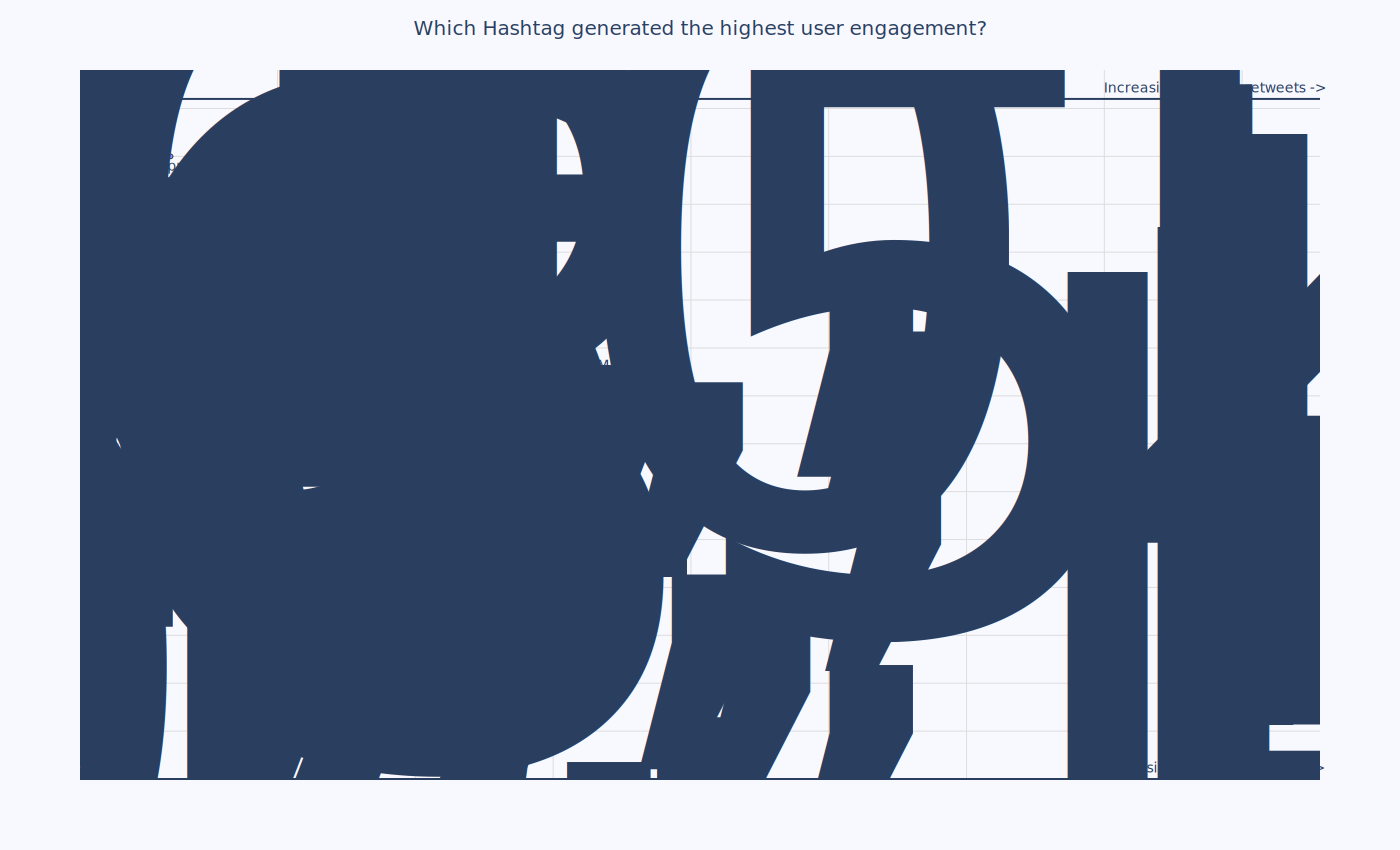

In [92]:
# --- Visualize results ---

# Create plot area
fig = px.scatter(hashtag_aggregates, y=hashtag_aggregates.index, x='retweets', size='likes',
                 text=hashtag_aggregates.index+'<br><sub>'+'Retweets: '+
                 hashtag_aggregates.retweets.astype(str)+', Likes: '+hashtag_aggregates.likes.astype(str)+'</sub>',
                 title='Which Hashtag generated the highest user engagement?<br>'+
                '<sup>Increasing retweets from left to right. Likes are represented by dot size.')

# Format traces and axes
fig.update_traces(textposition='bottom center', opacity=1, marker_line_color='black', marker_line_width=1)
fig.update_yaxes(showticklabels=False, gridcolor='#ddd')
fig.update_xaxes(showticklabels=False, gridcolor='#ddd')

# Update layout and annotations
fig.update_layout(height=850, width=1400, template='plotly_white', xaxis_title='', yaxis_title='',
                 paper_bgcolor='rgb(248, 248, 255)', plot_bgcolor='rgb(248, 248, 255)', 
                 font_family='Sathu', font_size=14, margin=dict(t=70, b=70), title_x=0.5)

fig.add_hline(y=13.2, annotation=dict(text=' Increasing average retweets ->'), annotation_position='top right')
fig.add_hline(y=-1, annotation=dict(text=' Increasing Average retweets ->'), annotation_position='top right')

fig.show('svg')

#### Findings:
>- **#WomensMarch** and **#ScienceMarch** gathered the highest share of interactions. On the other hand, hashtags such as **#Swole** and **#NoDaysOff** gained the least number of interactions.
   
---
### 6. How did the number of original posts, retweets and likes vary over the time period?
#### Logic:
>- Make a copy of the master dataframe and set the timestamp as the new dataframe index.
>- Resample the timestamp by month, aggregating the average number of posts, retweets, and likes in the process.
>- Visualize the results.

#### Action:

In [93]:
# Make a copy of the master dataframe, setting timestamp as the index
master_df_copy = master_df.set_index('timestamp')

# For each item to investigate, resample the dataframe by month
tweet_count = master_df_copy.tweet_id.resample('1m').count()
retweets= master_df_copy.retweets.resample('1m').mean()
likes = master_df_copy.likes.resample('1m').mean()

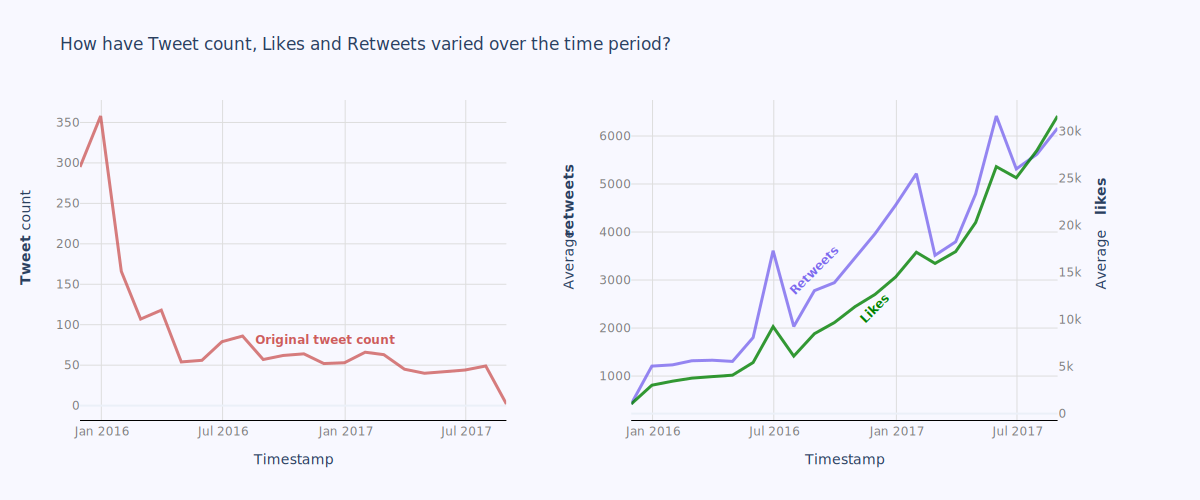

In [94]:
# Initialize figure with subplots
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.12,
                    specs=[[{"type": "scatter"}, {"secondary_y": True}]])

# Add trace for tweet count
fig.add_trace(
    go.Scatter(x=tweet_count.index, y=tweet_count.values, name='count of tweets', 
              marker_color='IndianRed'),row=1, col=1
)

# Add traces for retweets and likes
# Retweets
fig.add_trace(
    go.Scatter(x=retweets.index, y=retweets.values, name="retweets", marker_color='MediumSlateBlue'),
    secondary_y=False, row=1,col=2
)

# Likes
fig.add_trace(
    go.Scatter(x=likes.index, y=likes.values, name="likes", marker_color='green'),
    secondary_y=True, row=1, col=2
)

# Update traces and axes properties
fig.update_traces(line_width=3, opacity=0.8)
fig.update_yaxes(title_text="Average<b> retweets</b>", secondary_y=False, gridcolor='#ddd', 
                 tickfont_color='grey', row=1, col=2)
fig.update_yaxes(title_text="Average <b>likes</b>", secondary_y=True, showgrid=False, 
                 tickfont_color='grey', row=1, col=2)
fig.update_yaxes(title_text="<b>Tweet</b> count", gridcolor='#ddd', tickfont_color='grey', row=1, col=1)
fig.update_xaxes(title_text="Timestamp", gridcolor='#ddd', linecolor='black', tickfont_color='grey')


# Update layout and annotations
fig.update_layout(height=500, width=1200, template='plotly_white', showlegend=False, font_family='Sathu',
                 paper_bgcolor='rgb(248, 248, 255)', plot_bgcolor='rgb(248, 248, 255)',
                 title='How have Tweet count, Likes and Retweets varied over the time period?<br>'+
                 '<sup>Trends in original tweets, retweets and likes compared between Nov 2015 and Jul 2017.</sup>')

fig.add_annotation(x='2016-09', y=3200, text='<b>Retweets</b>', showarrow=False, 
                   textangle=-45, font_color='MediumSlateBlue', row=1, col=2)

fig.add_annotation(x='2016-12', y=2400, text='<b>Likes</b>', showarrow=False, 
                   textangle=-45, font_color='green', row=1, col=2)

fig.add_annotation(x='2016-12', y=80, text='<b>Original tweet count</b>', showarrow=False, 
                   textangle=0, font_color='IndianRed', row=1, col=1)

fig.show('svg')

#### Findings:
>- The total number of original tweets posted on the account has been declining overall. This _could_ have led one to believe that the account was gradually becoming unsuccessful with time.
>- The rising trend in retweets and favorites, however, tells a different story: Although the total number of tweets has been on a decline, the account has been gaining a lot of user interactions, moving from less than 1,000 retweets and 5,000 likes in late 2015, to over 6,000 retweets and 30,000 likes in late 2017.
>- This could be due to the fact that in earlier stages, an account may have created more tweets to gain popularity. As time progresses, people become familiar with the account. They may start to like and retweet contents for others to see. This can lead to a cycle of success, gradually reducing the need to create numerous contents before driving engagement.